# BBN for generating color and CurrentCondition
## Rate and cost are from our Bayesian Hierarchical model
## Z3 - Z3

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
import scipy.stats as st
import statsmodels.datasets
import scipy.stats as ss
import networkx as nx # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [124]:
# import original data 
df_all = pd.read_csv("./IMA_recommendation_simulation_data.csv")

# drop all rows which have NaN
df_all = df_all.dropna()

print(df_all.shape)

# only keep lead_days >= 0
df_all = df_all[df_all['lead_days'] >= 0]
print(df_all.shape)

(156569, 16)
(154929, 16)


In [125]:
# import zip codes for origin and destination
def zz(value):
    if value < 100:
        return 'Z0'
    elif value < 200:
        return 'Z1'
    elif value < 300:
        return 'Z2'
    elif value < 400:
        return 'Z3'
    elif value < 500:
        return 'Z4'
    elif value < 600:
        return 'Z5'
    elif value < 700:
        return 'Z6'
    elif value < 800:
        return 'Z7'
    elif value < 900:
        return 'Z8'
    elif value < 1000:
        return 'Z9'
    else:
        return 'Error'


df_all['ZipZone_origin'] = df_all.apply(lambda column: zz(column['origin_dat_ref']),axis=1)
df_all['ZipZone_dest'] = df_all.apply(lambda column: zz(column['dest_dat_ref']),axis=1)

In [126]:
# data for oirgin == Z3 and dest == Z3
# make a copy of the data for Z3 to Z3

df_Z33 = df_all.copy()
df_Z33 = df_all[(df_all['ZipZone_origin'] == 'Z3') & (df_all['ZipZone_dest'] == 'Z3')] #

df = df_Z33.copy()

print(df.shape)
df.head()

(13270, 18)


,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition,ZipZone_origin,ZipZone_dest
8,8,8f67eb6f89ff40bcb4289f1f62227df6,1,Wed,154,V,141.0,2,45679.0,6,YELLOW,326,347,-0.154330,-1.282368,Accepted,Z3,Z3
14,14,da4ec185b5644deea572fa379b9feed4,2,Wed,214,V,221.0,2,25677.0,7,GREEN,350,325,-0.099179,-0.129520,Accepted,Z3,Z3
17,17,f8a5bbfacc1b4e188fa7616da6c4207f,1,Wed,216,V,220.0,2,40349.0,8,RED,338,331,-0.869951,-0.933859,Rejected,Z3,Z3
21,21,9aac0768ac584c6d9459cf23dab7369a,1,Mon,57,V,60.0,2,39847.0,3,RED,328,338,-0.684707,-0.931124,Withdrawn,Z3,Z3
62,62,3278d00061f644a19c2c564da3888bcc,4,Wed,283,V,262.0,2,39478.0,2,RED,301,388,-1.285638,-1.147469,Rejected,Z3,Z3


df is the data from Z3 to Z3 without NaN and with lead_days >= 0.

In [127]:
print(df['rate_norm'].min())
print(df['rate_norm'].max())

-3.7589451195066377
10.373437924778138


In [128]:
print(df['est_cost_norm'].min())
print(df['est_cost_norm'].max())

-2.7355257108545605
3.829943705026474


We excluded the rows where rate_norm > 3 or est_cost_norm > 3.5 to match the catagory function in the following. (This can be skipped when making the category function more adaptable.)

In [129]:
# exclude rate > 3
print(df.shape)
df = df[df['rate_norm'] <= 3]
print(df.shape)

(13270, 18)
(13247, 18)


In [130]:
# exclude cost > 3.5
print(df.shape)
df = df[df['est_cost_norm'] <= 3.5]
print(df.shape)

(13247, 18)
(13247, 18)


In [131]:
print(df['rate_norm'].min())
print(df['rate_norm'].max())

-3.7589451195066377
2.939295167503741


In [132]:
print(df['est_cost_norm'].min())
print(df['est_cost_norm'].max())

-2.7355257108545605
3.18992775376824


In [133]:
# function for categaries of miles
def zz(value):
    for i in range(0,3400,1700):
        if value<= i+1700:
            return '<=%d' %(i+1700)
            break
            
# generate 2 categories for weight
def ww(value):
    for i in range(0,100000,50000):
        if value<= i+50000:
            return '<=%d' %(i+50000)
            break

# generate 4 categories for weight
def ww_4(value):
    for i in range(0,100000,25000):
        if value<= i+25000:
            return '<=%d' %(i+25000)
            break

# categorize rate
def rr(value):
    for i in range(-4,4,2): # 4 categories
        if value<= i+2:
            return '<=%d' %(i+2)
            break

# categorize cost
def cc(value):
    for i in range(-4,4,2): # 4 categories
        if value<= i+2:
            return '<=%d' %(i+2)
            break

In [134]:
# add category columns for rate_norm and eat_cost_norm
df['rate_cat']=df.apply(lambda column: rr(column['rate_norm']),axis=1)
df['cost_cat']=df.apply(lambda column: cc(column['est_cost_norm']),axis=1)

In [135]:
# show unique values for rate categories
column_values = df[["rate_cat"]].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['<=0' '<=2' '<=-2' '<=4']


In [136]:
# show unique values for cost categories
column_values = df[["cost_cat"]].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['<=0' '<=2' '<=4' '<=-2']


In [459]:
# export df for k-prototype
df.to_csv(r'/Users/miao/Desktop/IMA Boot Camp 2021 Summer/Project/original data for BBN.csv', index = False)

In [141]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None, parent3=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Work out the bands present in the parent variable
                bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            else:    
                # Work out the bands present in the parent variable
                bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).reindex(data[child].unique(), fill_value=0).sort_index().tolist()
                        prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [236]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 3 parents)
def probs_3(data, child, parent1=None, parent2=None, parent3=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None: # only has parent1
                # Work out the bands present in the parent variable
                bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            elif parent2!=None:  # has parent1 & parent2 
                #check if child node has parent3
                if parent3==None:
                    # Work out the bands present in the parent variable
                    bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                    bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                    # Caclucate probabilities
                    for val1 in bands1:
                        for val2 in bands2:
                            temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).reindex(data[child].unique(), fill_value=0).sort_index().tolist()
                            prob=prob+temp
                else: # child node has parent3
                    bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                    bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                    bands3=df[parent3].value_counts(sort=False).sort_index().index.tolist()
                    for val1 in bands1:
                        for val2 in bands2:
                            for val3 in bands3:
                                temp=data[(data[parent1]==val1) & (data[parent2]==val2) & (data[parent3]==val3)][child].value_counts(normalize=True).reindex(data[child].unique(), fill_value=0).sort_index().tolist()
                                prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [142]:
# to get the order of rate_cat
df['rate_cat'].value_counts(normalize=True, sort=False).sort_index() #.tolist()

<=-2    0.005360
<=0     0.828112
<=2     0.164264
<=4     0.002265
Name: rate_cat, dtype: float64

In [143]:
# to get the order of cost_cat
df['cost_cat'].value_counts(normalize=True, sort=False).sort_index()

<=-2    0.000981
<=0     0.810221
<=2     0.186684
<=4     0.002114
Name: cost_cat, dtype: float64

In [144]:
# to get the order of CurrentCondition
df[(df['rate_cat']=='<=2') & (df['cost_cat']=='<=2') & (df['color']=='RED')]['CurrentCondition'].value_counts(normalize=True).reindex(df['CurrentCondition'].unique(), fill_value=0).sort_index()


Accepted                     0.368074
Cancelled                    0.013193
NoPace                       0.000000
Rejected                     0.377309
Waiting On Acceptance        0.025066
Waiting On Recommendation    0.002639
Withdrawn                    0.213720
Name: CurrentCondition, dtype: float64

In [145]:
# to get the order of color
df[(df['rate_cat']=='<=2') & (df['cost_cat']=='<=2')]['color'].value_counts(normalize=True).reindex(df['color'].unique(), fill_value=0).sort_index()


GREEN     0.336879
RED       0.537589
YELLOW    0.125532
Name: color, dtype: float64

## generate color from rate and cost

In [146]:
# the orders go to here
rate = BbnNode(Variable(0, 'rate',['<=-2', '<=0', '<=2', '<=4'] ), probs(df, child='rate_cat'))
cost = BbnNode(Variable(1, 'cost',['<=-2', '<=0', '<=2', '<=4'] ), probs(df, child='cost_cat'))

color = BbnNode(Variable(2, 'color', ['GREEN', 'RED', 'YELLOW']), probs(df, child='color', parent1 = 'rate_cat', parent2='cost_cat'))


In [147]:
# Create Network
bbn = Bbn() \
    .add_node(rate) \
    .add_node(cost) \
    .add_node(color) \
    .add_edge(Edge(rate, color, EdgeType.DIRECTED)) \
    .add_edge(Edge(cost, color, EdgeType.DIRECTED)) 

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

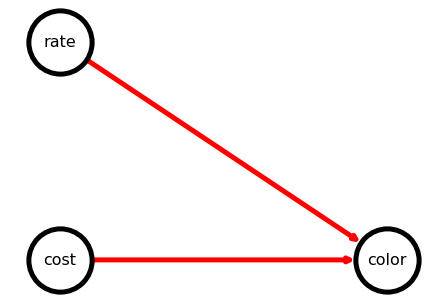

In [148]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [149]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|cost|<=-2,<=0,<=2,<=4
Values:
1=<=-2|0.00098
1=<=0|0.81166
1=<=2|0.18701
1=<=4|0.00035
----------------
Node: 2|color|GREEN,RED,YELLOW
Values:
2=GREEN|0.27227
2=RED|0.58036
2=YELLOW|0.14737
----------------
Node: 0|rate|<=-2,<=0,<=2,<=4
Values:
0=<=-2|0.00535
0=<=0|0.82783
0=<=2|0.16455
0=<=4|0.00227
----------------


In [150]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [172]:
# one example
# can be skipped
evidence('ev1', 'rate', '<=2', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|cost|<=0,<=2,<=4,<=-2
Values:
1=<=0|0.00098
1=<=2|0.81194
1=<=4|0.18708
1=<=-2|0.00000
----------------
Node: 2|color|GREEN,RED,YELLOW
Values:
2=GREEN|0.20827
2=RED|0.63485
2=YELLOW|0.15689
----------------
Node: 0|rate|<=0,<=2,<=-2,<=4
Values:
0=<=0|0.00000
0=<=2|1.00000
0=<=-2|0.00000
0=<=4|0.00000
----------------


In [152]:
colors=join_tree.get_posteriors().get('color')
join_tree.get_posteriors().get('color')

{'GREEN': 0.27227394188716897,
 'RED': 0.5803590304663594,
 'YELLOW': 0.14736702764647153}

In [153]:
# assign color for a given input
def color_probs(cat1,cat2):
    evidence('ev1', 'rate', cat1, 1.0)
    evidence('ev2', 'cost', cat2, 1.0)
    colors=join_tree.get_posteriors().get('color')
    g = colors.get('GREEN')
    r = colors.get('RED')
    y = colors.get('YELLOW')
    a = np.random.uniform()
    interval = [0,g,g+r,1]
    if (a>=0 and a<g):
        return 'GREEN'
    elif (a>=g and a<g+r):
        return 'RED'
    else:
        return 'YELLOW'

In [260]:
##### Another way of assigning color or current condition by taking max prob
#def condition_probs_max(cat1,cat2, cat3):
#    evidence('ev1', 'rate', cat1, 1.0)
#    evidence('ev2', 'cost', cat2, 1.0)
#    evidence('ev3', 'color', cat3, 1.0)
#    conditions=join_tree.get_posteriors().get('current_condition')
#    max_key = max(conditions, key=conditions.get)
#    return max_key


In [172]:
# import generated data got from Hierarchical model

gen_all = pd.read_csv("./generated_data_Z3_new.csv")
gen_all = gen_all.dropna()

df_gen = gen_all.copy()

In [173]:
# categorize

# add categories for rate_norm and eat_cost_norm
df_gen['rate_cat']=df_gen.apply(lambda column: rr(column['rate_norm']),axis=1)
df_gen['cost_cat']=df_gen.apply(lambda column: cc(column['est_cost_norm']),axis=1)


In [174]:
df_gen.head()

,Unnamed: 0,order_distance,order_origin_weight,lead_days,week_id,rate_norm,est_cost_norm,rate_cat,cost_cat
0,0,328.887342,37423.671484,5,3,0.745465,0.258851,<=2,<=2
1,1,432.511533,44112.233825,5,4,0.822597,0.833778,<=2,<=2
2,2,544.555273,38315.198374,7,3,1.182238,0.944255,<=2,<=2
3,3,138.258376,40953.390305,1,4,-0.397974,-0.482964,<=0,<=0
4,4,319.227262,41972.466041,1,4,-0.869040,0.306075,<=0,<=2


In [175]:
print(df_gen['est_cost_norm'].min())
print(df_gen['est_cost_norm'].max())

-4.111713855428855
8.046966050706052


In [176]:
sum(df_gen['est_cost_norm']>4)/len(df_gen['est_cost_norm'])

0.0024615384615384616

In [177]:
sum(df_gen['est_cost_norm']<-4)/len(df_gen['est_cost_norm'])

7.692307692307693e-05

In [183]:
# Since the percentages ofcost >4 or <-4 are very small, so we excluded them to match the category function
print(df_gen.shape[0])
df_gen = df_gen[(df_gen['est_cost_norm']<=4)]
print(df_gen.shape[0])
df_gen = df_gen[(df_gen['est_cost_norm']>=-4)]
print(df_gen.shape[0])

13000
12968
12967


In [184]:
# same for rate >4 or <-4
print(df_gen.shape[0])
df_gen = df_gen[(df_gen['rate_norm']<=4)]
print(df_gen.shape[0])
df_gen = df_gen[(df_gen['rate_norm']>=-4)]

12967
12961


In [185]:
# categorize

# add cat for rate_norm and eat_cost_norm
df_gen['rate_cat']=df_gen.apply(lambda column: rr(column['rate_norm']),axis=1)
df_gen['cost_cat']=df_gen.apply(lambda column: cc(column['est_cost_norm']),axis=1)

In [186]:
# show unique values 
column_values = df_gen[["cost_cat"]].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['<=2' '<=0' '<=4' '<=-2']


In [187]:
print(df_gen['rate_norm'].min())
print(df_gen['rate_norm'].max())

-3.7387363191439382
3.9420598309288817


In [188]:
# show unique values 
column_values = df_gen[["rate_cat"]].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['<=2' '<=0' '<=4' '<=-2']


In [189]:
# First, generate color

rate_list = list(df_gen['rate_cat'])
cost_list = list(df_gen['cost_cat'])


In [190]:
df_gen['color']=[color_probs(rate_list[i],cost_list[i]) for i in range(0,len(rate_list))]

In [191]:
df_gen.head(20)

,Unnamed: 0,order_distance,order_origin_weight,lead_days,week_id,rate_norm,est_cost_norm,rate_cat,cost_cat,color
0,0,328.887342,37423.671484,5,3,0.745465,0.258851,<=2,<=2,RED
1,1,432.511533,44112.233825,5,4,0.822597,0.833778,<=2,<=2,RED
2,2,544.555273,38315.198374,7,3,1.182238,0.944255,<=2,<=2,RED
3,3,138.258376,40953.390305,1,4,-0.397974,-0.482964,<=0,<=0,RED
4,4,319.227262,41972.466041,1,4,-0.869040,0.306075,<=0,<=2,RED
5,5,90.617943,48019.475959,3,3,-1.178395,0.142147,<=0,<=2,RED
6,6,145.740446,44598.485325,6,2,-0.299977,-0.016159,<=0,<=0,YELLOW
7,7,409.085414,43607.160108,1,1,0.413795,0.916850,<=2,<=2,YELLOW
8,8,458.566608,18939.508205,3,1,1.333874,1.492821,<=2,<=2,GREEN
9,9,417.022787,45328.957670,5,2,0.937783,2.047398,<=2,<=4,RED


Check the probabilities in original data and generated data for color

In [192]:
df_gen['color'].value_counts(normalize=True)

RED       0.570029
GREEN     0.294467
YELLOW    0.135504
Name: color, dtype: float64

In [193]:
df['color'].value_counts(normalize=True)

RED       0.580358
GREEN     0.261795
YELLOW    0.157847
Name: color, dtype: float64

## generate CurrentCondition using generated color from BBN and rate and cost from Hierarchical model

In [194]:
                                
rate = BbnNode(Variable(0, 'rate',['<=-2', '<=0', '<=2', '<=4'] ), probs_3(df, child='rate_cat'))
cost = BbnNode(Variable(1, 'cost',['<=-2', '<=0', '<=2', '<=4'] ), probs_3(df, child='cost_cat'))

color = BbnNode(Variable(2, 'color', ['GREEN', 'RED', 'YELLOW']), probs_3(df, child='color'))
current_condition = BbnNode(Variable(3, 'current_condition', ['Accepted', 'Cancelled', 'NoPace', 'Rejected', 'Waiting On Acceptance', 'Waiting On Recommendation', 'Withdrawn']), probs_3(df, child='CurrentCondition', parent1='rate_cat', parent2='cost_cat', parent3='color'))



In [195]:
# Create Network
bbn = Bbn() \
    .add_node(rate) \
    .add_node(cost) \
    .add_node(color) \
    .add_node(current_condition) \
    .add_edge(Edge(rate, current_condition, EdgeType.DIRECTED)) \
    .add_edge(Edge(cost, current_condition, EdgeType.DIRECTED)) \
    .add_edge(Edge(color, current_condition, EdgeType.DIRECTED)) 

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

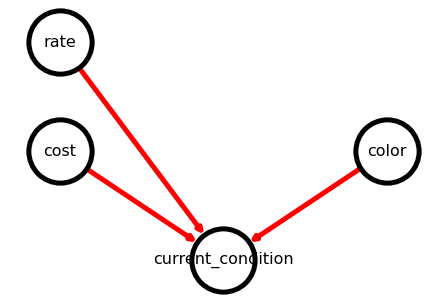

In [196]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [57]:
# a simple test
# can be skipped
evidence('ev1', 'rate', '<=2', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|cost|<=-1,<=1,<=3,<=5
Values:
1=<=-1|0.15325
1=<=1|0.81786
1=<=3|0.02887
1=<=5|0.00002
----------------
Node: 2|color|GREEN,RED,YELLOW
Values:
2=GREEN|0.63435
2=RED|0.29110
2=YELLOW|0.07455
----------------
Node: 3|current_condition|Accepted,Cancelled,NoPace,Rejected,Waiting On Acceptance,Waiting On Recommendation,Withdrawn
Values:
3=Accepted|0.56369
3=Cancelled|0.01025
3=NoPace|0.00060
3=Rejected|0.21930
3=Waiting On Acceptance|0.00604
3=Waiting On Recommendation|0.00051
3=Withdrawn|0.19961
----------------
Node: 0|rate|<=2,<=8,<=14
Values:
0=<=2|0.00000
0=<=8|1.00000
0=<=14|0.00000
----------------


In [197]:
##### to assign condition for a given input
def condition_probs(cat1,cat2, cat3):
    evidence('ev1', 'rate', cat1, 1.0)
    evidence('ev2', 'cost', cat2, 1.0)
    evidence('ev3', 'color', cat3, 1.0)
    conditions=join_tree.get_posteriors().get('current_condition')

    accept = conditions.get('Accepted')
    cancelled = conditions.get('Cancelled')
    nopace = conditions.get('NoPace')
    rejected = conditions.get('Rejected')
    w_a = conditions.get('Waiting On Acceptance')
    w_r = conditions.get('Waiting On Recommendation')
    wd = conditions.get('Withdrawn')
    a = np.random.uniform()
    interval = [0,accept,accept+cancelled, accept+cancelled+nopace, accept+cancelled+nopace+rejected, accept+cancelled+nopace+rejected+w_a, accept+cancelled+nopace+rejected+w_a+w_r, accept+cancelled+nopace+rejected+w_a+w_r+wd, 1]
    if (a>=0 and a<=accept):
        return 'Accepted'
    elif (a>accept and a<=accept+cancelled):
        return 'Cancelled'
    elif (a>accept+cancelled and a<=accept+cancelled+nopace):
        return 'NoPace'
    elif (a>accept+cancelled+nopace and a<=accept+cancelled+nopace+rejected):
        return 'Rejected'
    elif (a>accept+cancelled+nopace+rejected and a<=accept+cancelled+nopace+rejected+w_a):
        return 'Waiting On Acceptance'
    elif (a>accept+cancelled+nopace+rejected+w_a and a<=accept+cancelled+nopace+rejected+w_a+w_r):
        return 'Waiting On Recommendation'
    elif (a>accept+cancelled+nopace+rejected+w_a+w_r and a<=1):
        return 'Withdrawn'
 

In [198]:
rate_list = list(df_gen['rate_cat'])
cost_list = list(df_gen['cost_cat'])
color_list = list(df_gen['color'])

In [200]:
# generate CurrentCondition
df_gen['CurrentCondition'] = [condition_probs(rate_list[i],cost_list[i], color_list[i]) for i in range(0,len(rate_list))]


In [201]:
df_gen.head(20)

,Unnamed: 0,order_distance,order_origin_weight,lead_days,week_id,rate_norm,est_cost_norm,rate_cat,cost_cat,color,CurrentCondition
0,0,328.887342,37423.671484,5,3,0.745465,0.258851,<=2,<=2,RED,Accepted
1,1,432.511533,44112.233825,5,4,0.822597,0.833778,<=2,<=2,RED,Rejected
2,2,544.555273,38315.198374,7,3,1.182238,0.944255,<=2,<=2,RED,Rejected
3,3,138.258376,40953.390305,1,4,-0.397974,-0.482964,<=0,<=0,RED,Accepted
4,4,319.227262,41972.466041,1,4,-0.869040,0.306075,<=0,<=2,RED,Withdrawn
5,5,90.617943,48019.475959,3,3,-1.178395,0.142147,<=0,<=2,RED,Accepted
6,6,145.740446,44598.485325,6,2,-0.299977,-0.016159,<=0,<=0,YELLOW,Rejected
7,7,409.085414,43607.160108,1,1,0.413795,0.916850,<=2,<=2,YELLOW,Rejected
8,8,458.566608,18939.508205,3,1,1.333874,1.492821,<=2,<=2,GREEN,Accepted
9,9,417.022787,45328.957670,5,2,0.937783,2.047398,<=2,<=4,RED,Accepted


In [202]:
df_gen.shape

(12959, 11)

In [203]:
# show unique values
column_values = df_gen[["CurrentCondition"]].values.ravel()
unique_values =  pd.unique(column_values)
print(unique_values)

['Accepted' 'Rejected' 'Withdrawn' 'Waiting On Acceptance' 'Cancelled'
 'Waiting On Recommendation' 'NoPace']


In [204]:
# check probabilities
df_gen['CurrentCondition'].value_counts(normalize=True).sort_index()

Accepted                     0.568254
Cancelled                    0.010495
NoPace                       0.000077
Rejected                     0.217146
Waiting On Acceptance        0.007794
Waiting On Recommendation    0.000309
Withdrawn                    0.195926
Name: CurrentCondition, dtype: float64

In [205]:
df['CurrentCondition'].value_counts(normalize=True).sort_index()

Accepted                     0.564354
Cancelled                    0.010191
NoPace                       0.000604
Rejected                     0.218917
Waiting On Acceptance        0.006039
Waiting On Recommendation    0.000528
Withdrawn                    0.199366
Name: CurrentCondition, dtype: float64

In [206]:
df_gen['color'].value_counts(normalize=True).sort_index()

GREEN     0.294467
RED       0.570029
YELLOW    0.135504
Name: color, dtype: float64

In [207]:
df['color'].value_counts(normalize=True).sort_index()

GREEN     0.261795
RED       0.580358
YELLOW    0.157847
Name: color, dtype: float64

Plots colored by color and current consitions in bith original and genearted data.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scatter plot for original data')

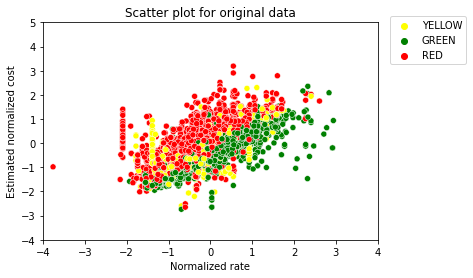

In [223]:
p1 = sns.scatterplot('rate_norm', 'est_cost_norm', hue = 'color', data = df, ci=None, palette=["yellow", "green", "red"])
p1.set(xlim=(-4, 4))
p1.set(ylim=(-4, 5))
plt.ylabel("Estimated normalized cost")
plt.xlabel("Normalized rate")
p1.legend(bbox_to_anchor=(1.28, 1.05))
plt.title("Scatter plot for original data")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scatter plot for generated data')

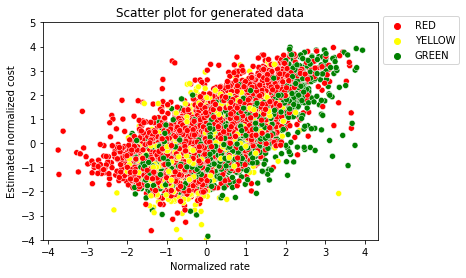

In [222]:
p2 = sns.scatterplot('rate_norm', 'est_cost_norm', hue = 'color', data = df_gen, ci=None, palette=["red", "yellow", "green"])
#p2.set(xlim=(-4, 3))
p2.set(ylim=(-4, 5))
plt.ylabel("Estimated normalized cost")
plt.xlabel("Normalized rate")
p2.legend(bbox_to_anchor=(1, 1.05))
plt.title("Scatter plot for generated data")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scatter plot for generated data')

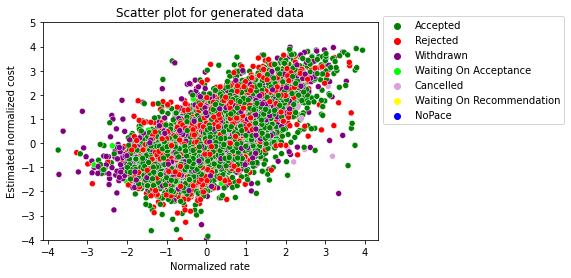

In [225]:
p3 = sns.scatterplot('rate_norm', 'est_cost_norm', hue = 'CurrentCondition', data = df_gen, palette=["green", "red", "purple", "lime", "plum","yellow", "blue"],ci=None) #, palette=["yellow", "green", "red"]
#p3.set(xlim=(-4, 4))
p3.set(ylim=(-4, 5))
plt.ylabel("Estimated normalized cost")
plt.xlabel("Normalized rate")
p3.legend(bbox_to_anchor=(1, 1.05))
plt.title("Scatter plot for generated data")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scatter plot for original data')

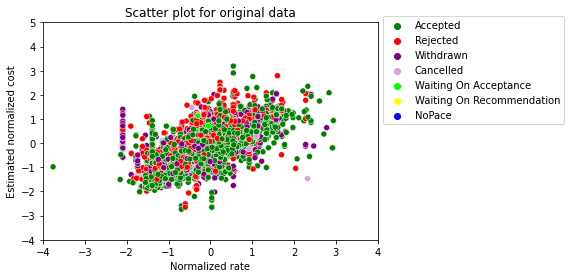

In [226]:
p4 = sns.scatterplot('rate_norm', 'est_cost_norm', hue = 'CurrentCondition', data = df, palette=["green", "red", "purple", "plum", "lime","yellow", "blue"], ci=None) #, palette=["yellow", "green", "red"]
p4.legend(bbox_to_anchor=(1, 1.05))
p4.set(xlim=(-4, 4))
p4.set(ylim=(-4, 5))
plt.ylabel("Estimated normalized cost")
plt.xlabel("Normalized rate")
plt.title("Scatter plot for original data")

In [456]:
df_gen.head()

,order_distance,order_origin_weight,lead_days,rate_norm,est_cost_norm,rate_cat,cost_cat,color,CurrentCondition
0,328.257701,37433.077412,5,-0.909170,-0.203808,<=0,<=0,GREEN,Accepted
1,431.908489,44121.642933,5,0.139150,-1.555251,<=2,<=0,GREEN,Rejected
2,543.955732,38324.604726,7,0.363895,-0.039376,<=2,<=0,YELLOW,Accepted
3,137.859769,40962.797911,1,-0.059074,-0.824165,<=0,<=0,YELLOW,Accepted
4,318.670795,41981.874131,1,0.237177,-0.865398,<=2,<=0,GREEN,Withdrawn


In [224]:
# export the generated data to a csv file
df_gen.to_csv(r'/Users/miao/Desktop/IMA Boot Camp 2021 Summer/Project/generated data from BBN new Z3.csv', index = False)